In [1]:
%matplotlib inline

This notebook reproduces 

> **Fig 6**: Dependence of the relative energies of all $n=2$ eigenstates in Ps on electric-field strength (a) in the absence of a magnetic field and (b) in a parallel magnetic field of B=130 G...

from the article

> #### Positronium decay from $n = 2$ states in electric and magnetic fields
>
> A. M. Alonso, B. S. Cooper, A. Deller, S. D. Hogan, and D. B. Cassidy.
>
> *Phys. Rev. A*, **93**, 012506 (2016) [DOI:10.1103/PhysRevA.93.012506](https://dx.doi.org/10.1103/PhysRevA.93.012506)

In [2]:
# packages
import os
from functools import reduce
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from psfs import Hamiltonian, En_h, h
# https://github.com/ad3ller/Stark-map-tools
from smtools import sm_sort, lc_cmap

In [3]:
# construct matrix
mat = Hamiltonian(n_min=1, n_max=3, MJ_max=None)
print('number of basis states:', '%d'%mat.num_states)

number of basis states: 56


In [4]:
# calculate Stark map
Efield = np.linspace(0, 3000, 1000)  # V / cm
Bfield = 0.013 # T
triplet_states = mat.where('S', 1)
sm0, amp0 = mat.stark_map(Efield*1e2, eig_amp=triplet_states, tqdm_disable=True)
sm013, amp013 = mat.stark_map(Efield*1e2, Bfield=Bfield, eig_amp=triplet_states, tqdm_disable=True)
# sorting
sm0, amp0 = sm_sort(sm0, amp0)
sm013, amp013 = sm_sort(sm013, amp013)
# ensure 0 < amp0 < 1
amp0 = np.clip(amp0, 0, 1)
amp013 = np.clip(amp013, 0, 1)

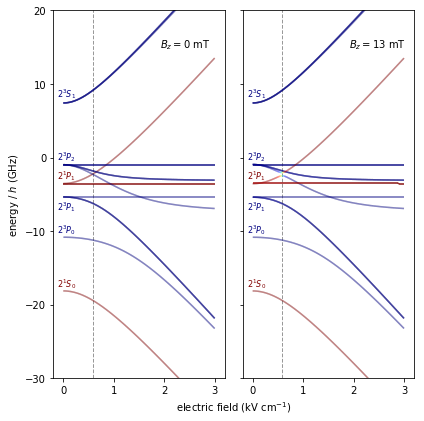

In [5]:
cmap = cm.jet_r
# plot
fig, ax = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(6, 6))

# n=2 Bohr model energy offset
yoffset = En_h / 16.0

# plot
ixs = mat.where('n', 2)
for ix in ixs:
    cs = cmap(amp0[:, ix], alpha=0.6)
    lc = lc_cmap(1e-3*Efield, 1e-9*(sm0[:, ix] + yoffset) / h, cs)
    lc.set_linewidth(1.5)
    ax[0].add_collection(lc)

    cs = cmap(amp013[:, ix], alpha=0.6)
    lc = lc_cmap(1e-3*Efield, 1e-9*(sm013[:, ix] + yoffset) / h, cs)
    lc.set_linewidth(1.5)
    ax[1].add_collection(lc)

# avoided crossing
ax[0].axvline(0.58, ls='--', c = 'k', lw=1, alpha=0.4, zorder=-20)
ax[1].axvline(0.58, ls='--', c='k', lw=1, alpha=0.4, zorder=-20)    

# labels
indx = reduce(np.intersect1d, (mat.where('n', 2),
                               mat.where('MJ', 0)))
lbl_adjust = [0.6, 0.6, -1.7, 0.6, 0.7, 0.8]
for i, ix in enumerate(indx):
    el = mat.basis[ix]
    c = cmap(float(el.S))
    lbl = el.tex(show_MJ=False)
    en = 1e-9*(el.E0 *En_h + yoffset)/h
    ax[0].annotate(lbl, [-0.12, en + lbl_adjust[i]], size=8, color=c)
    ax[1].annotate(lbl, [-0.12, en + lbl_adjust[i]], size=8, color=c)

# format
ax[0].set_ylabel('energy / $h$ (GHz)')
ax[0].set_ylim(-30, 20)
ax[0].set_xlim(-0.2, 3.2)
ax[0].text(0.62, 0.9, r'$B_z = 0$ mT', transform=ax[0].transAxes)
ax[1].text(0.62, 0.9, r'$B_z = %d$ mT'%(Bfield*1e3), transform=ax[1].transAxes)
# shared x-label
plt.tight_layout(rect=[0, 0.05, 1, 1])
fig.text(0.55, 0.04, 'electric field (kV cm$^{-1}$)', ha='center')

# output
fileout = os.path.join("../images/stark_n2.png")
plt.savefig(fileout, dpi=150)
plt.show()

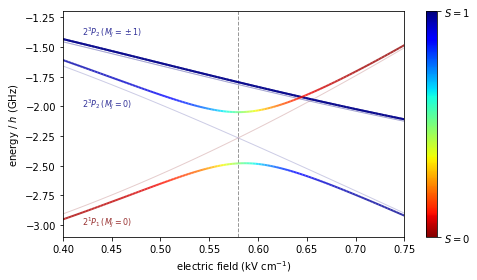

In [6]:
fig, ax = plt.subplots(figsize=(7, 4))

# n=2 Bohr model energy offset
yoffset = En_h / 16.0

# plot
ixs = mat.where('n', 2)
for ix in ixs:
    cs = cmap(amp0[:, ix], alpha=0.8)
    lc = lc_cmap(1e-3*Efield, 1e-9*(sm0[:, ix] + yoffset) / h, cs)
    lc.set_linewidth(1)
    lc.set_alpha(0.2)
    lc.set_zorder(-10)
    ax.add_collection(lc)
    
    cs = cmap(amp013[:, ix], alpha=0.8)
    lc = lc_cmap(1e-3*Efield, 1e-9*(sm013[:, ix] + yoffset) / h, cs)
    lc.set_linewidth(2)
    ax.add_collection(lc)

# avoided crossing
ax.axvline(0.580, ls='--', c='k', lw=1, alpha=0.4, zorder=-20)    

# labels
pos = np.argmin(abs(1e-3*Efield - 0.42))
indx = reduce(np.intersect1d, (mat.where('n', 2), mat.where('l', 1), mat.where('S', 0), mat.where('MJ', 0)))[0]
lbl = mat.basis[indx].tex()
c = cmap(amp0[pos, indx], alpha=0.8)
ax.annotate(lbl, [0.42, -3.0], size=8, color=c)

indx = reduce(np.intersect1d, (mat.where('n', 2), mat.where('l', 1), mat.where('S', 1), mat.where('J', 2), mat.where('MJ', 0)))[0]
lbl = mat.basis[indx].tex()
c = cmap(amp0[pos, indx], alpha=0.8)
ax.annotate(lbl, [0.42, -2.0], size=8, color=c)

indx = reduce(np.intersect1d, (mat.where('n', 2), mat.where('l', 1), mat.where('S', 1), mat.where('J', 2), mat.where('MJ', 1)))[0]
lbl = mat.basis[indx].tex()
lbl = lbl.replace('= 1', r'= \pm 1')
c = cmap(amp0[pos, indx], alpha=0.8)
ax.annotate(lbl, [0.42, -1.4], size=8, color=c)

# colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=1))
sm._A = []
cbar = plt.colorbar(sm, ticks=[0, 1])
cbar.ax.set_yticklabels([r'$S = 0$', r'$S = 1$'])

# format
ax.set_ylabel('energy / $h$ (GHz)')
ax.set_xlabel('electric field (kV cm$^{-1}$)')
ax.set_ylim(-3.1, -1.2)
ax.set_xlim(0.4, 0.75)

plt.tight_layout()
# output
fileout = os.path.join("../images/stark_n2_zoom.png")
plt.savefig(fileout, dpi=150)
plt.show()